In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import get_named_colors_mapping
from pathlib import Path
from scipy.signal import convolve

In [25]:
indir = Path('./data')

In [24]:
def to_color(wl: float):
    cmap = get_named_colors_mapping()
    if wl >= 380 and wl < 450:
        color = 'violet'
    elif wl >= 450 and wl < 485:
        color = 'blue'
    elif wl >= 485 and wl < 500:
        color = 'cyan'
    elif wl >= 500 and wl < 565:
        color = 'green'
    elif wl >= 565 and wl < 590:
        color = 'yellow'
    elif wl >= 590 and wl < 625:
        color = 'orange'
    elif wl >= 625 and wl < 750:
        color = 'red'
    else:
        color = 'black'
    return cmap[color]

In [68]:
def parse(lines: list[str], sep: str = ';'):
    meta = {}
    data = ([], [])
    for line in lines:
        if sep in line:
            x, y = line.strip().split(sep)
            try:
                x = float(x)
                y = float(y)
                data[0].append(x)
                data[1].append(y)
            except ValueError:
                meta[x] = y
                
    return np.array(data), meta

def read_data_from_path(p: Path):
    data, meta = None, None
    with open(p, 'r') as fp:
        data, meta = parse(fp.readlines())
    return data, meta

def plot_spectrum(x, y, ax, smooth=True, title=''):
    ax.set_title(title)
    if smooth: 
        y = convolve(y, np.ones((7,))/7, mode='same')
    ax.scatter(x, y, c=[to_color(wl) for wl in x], s=2)
    ax.set_xlabel('lambda [nm]')
    ax.set_ylabel('intensity')

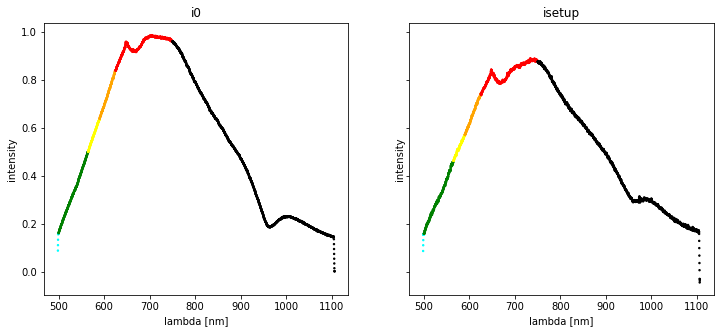

In [72]:
i0, meta0 = read_data_from_path(indir / 'trans_background.csv')
isetup, metasetup = read_data_from_path(indir / 'scat_background.csv')

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
axes = np.ravel(axes)
plot_spectrum(*i0, axes[0], title='i0')
plot_spectrum(*isetup, axes[1], title='isetup')
plt.show()
plt.close(fig)

In [5]:
def transmittance(it, i0):
    return it / i0

def absorbance(it, i0):
    return -np.log10(it / i0)

def scattering(isc, isetup):
    return isc / isetup

def flourescence(ifl, isetup):
    return ifl / isetup

In [97]:
def color_info(p: Path):
    p = str(p)
    if 'blue' in p:
        return 'blue'
    elif 'green' in p:
        return 'green'
    elif 'red' in p:
        return 'red'
    else:
        return 'white'
    
def plot_by_patterns(patterns, funcs, irefs, filter=None, integration_times=None, cutoff=None, verbose=False):

    if filter is None:
        filter = lambda p: p
        
    for paths in zip(*[sorted( filter(indir.glob(pattern)) ) for pattern in patterns]):
        fig, axes = plt.subplots(1, len(paths), sharex=True, sharey=False, figsize=(12, 5))
        axes = np.ravel(axes)
        
        for idx in range(len(paths)):
            
            i, meta = read_data_from_path(paths[idx])
            
            integration_time = float(meta['#IntegrationTime'])
            sample = str(paths[idx]).split('_sample')[1][0]
            color = color_info(paths[idx])
            
            if integration_times is not None:
                corrfac = integration_times[idx] / integration_time
            else:
                corrfac = 1.0
        
            if verbose:
                print('min, max =', np.min(i[1]), np.max(i[1]))
                print('corrfac =', corrfac)
        
            title = f'{sample} - {funcs[idx].__name__} - {color} - {integration_time} - {integration_times[idx]}'
        
            mask = (i[1] * irefs[idx][1] > 0)
            
            if cutoff is not None:
                mask = np.logical_and(mask, i[0] <= cutoff)
            plot_spectrum(
                i[0][mask], funcs[idx](i[1][mask], irefs[idx][1][mask]) * corrfac,
                axes[idx],
                title=title,
            )
        
        plt.show()
        plt.close(fig)

In [88]:
def filter_by_sample_number(low, high):
    def filter(paths):
        filtered_paths = []
        for p in paths:
            num = int(str(p).split('_sample')[1][0])
            if num >= low and num <= high:
                filtered_paths.append(p)
        return filtered_paths
    return filter

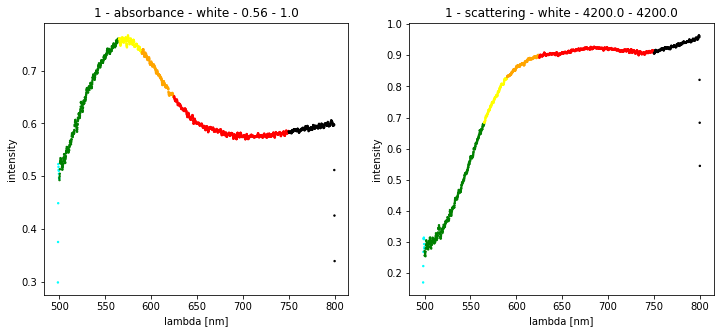

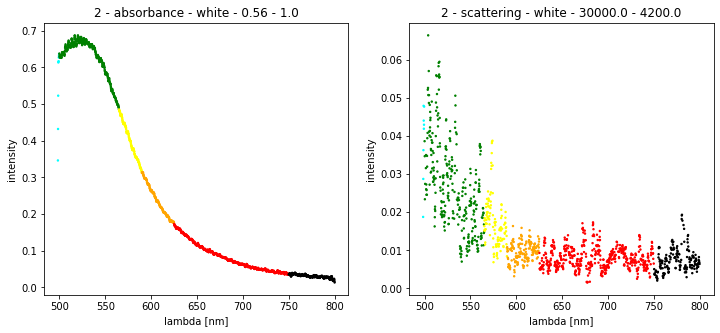

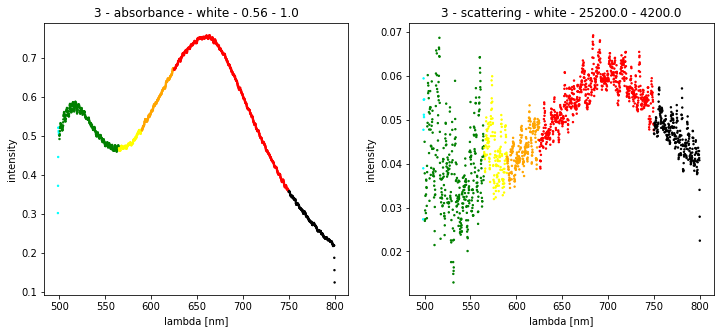

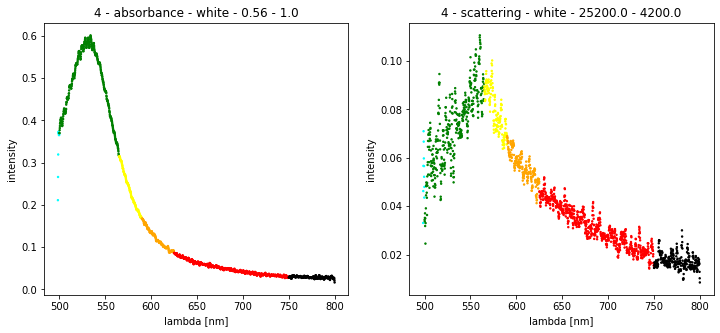

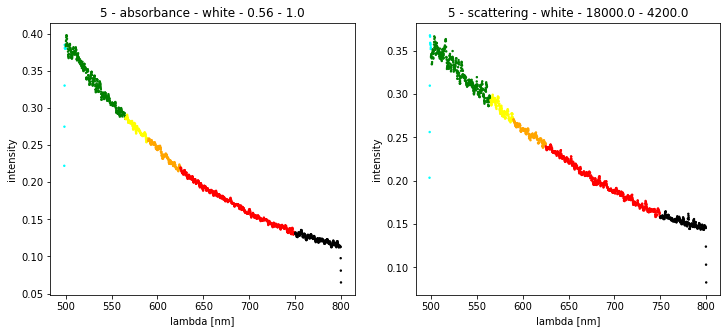

In [98]:
plot_by_patterns(
    ['trans_sample*.csv', 'scat_sample*.csv'],
    [absorbance, scattering],
    [i0, isetup],
    filter_by_sample_number(1, 5),
    [1.0, 4200.0],
    800.0
)

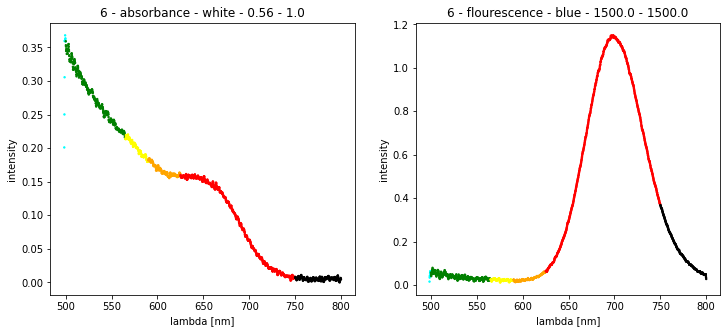

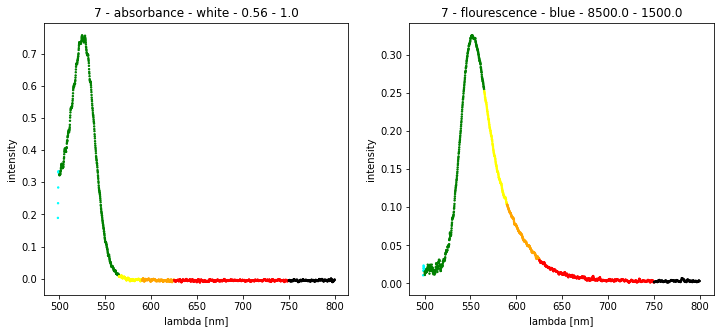

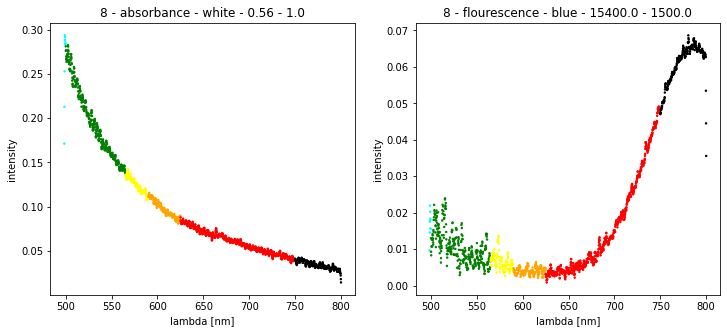

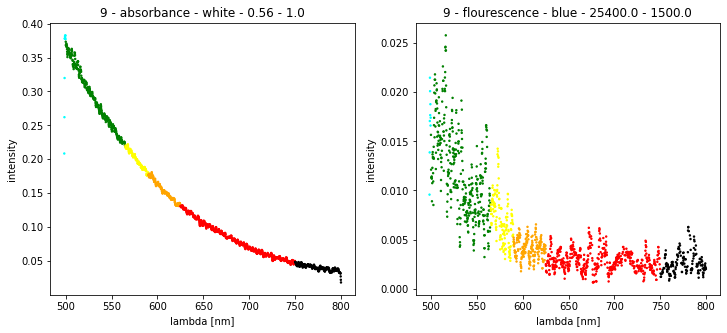

In [99]:
plot_by_patterns(
    ['trans_sample*.csv', 'flur_sample*_blue.csv'],
    [absorbance, flourescence],
    [i0, isetup],
    filter_by_sample_number(6, 9),
    [1.0, 1500.0],
    800.0
)